## This notebook uses functions from others (with some tweaking) to produce some slide images for our presentation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import cumfreq
%matplotlib inline

In [2]:
# Copied many ipy_util functions here, probably unnecessarily
def get_tissue_list(tissue_fpath):
    tissue_file = open(tissue_fpath)
    for line in tissue_file:
        tissues = line.rstrip().split('\t')
        break
    return tissues

def map_GO_to_GTEX():
    inputFilename = '../data/GO_terms_final_gene_counts.txt'
    GO_list_file = open(inputFilename)
    GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')
    
    inputFilename = '../data/Tissue_Name_Mappings.csv'
    tissue_data = pd.read_csv(inputFilename,header=None)
    map_BTO_to_GTEX = defaultdict(list)

    for index,row in tissue_data.iterrows():
        GTEX_tissue = row[0]
        BTO_tissues = row[1:]
        for tissue in BTO_tissues.dropna():
            map_BTO_to_GTEX[tissue].append(GTEX_tissue)



    inputFilename = '../data/BTO_GO.csv'
    BTO_data = pd.read_csv(inputFilename,skiprows=[0])
    map_GO_to_GTEX = defaultdict(list)

    for index,row in BTO_data.iterrows():
        tissue = row[1]
        if tissue in map_BTO_to_GTEX:
            GO_IDs = row[2:]
            for GO_ID in GO_IDs.dropna():
                if GO_ID in GO_list:
                    map_GO_to_GTEX[GO_ID] = map_GO_to_GTEX[GO_ID] + map_BTO_to_GTEX[tissue]
    #inputFile.close()
    return map_GO_to_GTEX

def map_GTEX_to_GO(map_GO_to_GTEX):
    GTEX_to_GO = defaultdict(list)
    for GO_ID,tissues in map_GO_to_GTEX.items():
        for tissue in tissues:
            if GO_ID not in GTEX_to_GO[tissue]:
                GTEX_to_GO[tissue].append(GO_ID)
    return GTEX_to_GO

def map_GTEX_to_cols(dir_path, tissues):
    GTEX_to_samples = {}
    for tissue in tissues:
        cols = []
        fpath = dir_path + 'tissue_meta_' + tissue + '.txt'
        meta_file = open(fpath)
        for (i, line) in enumerate(meta_file):
            if i < 1:
                continue
            else:
                cols.append(int(line.split('\t')[0]))
        GTEX_to_samples[tissue] = cols
        meta_file.close()
    return GTEX_to_samples

def get_1_tissue_aucs(GO_term, tissue_list, results_dir):
    aucs_1_tissue = []

    for tissue in tissue_list:
        # Get the AUC score when using features from only this tissue
        f_name = results_dir + 'logreg_' + tissue + '.txt'
        rf = open(f_name)
        for (i, line) in enumerate(rf):
            if i == 2:
                auc_score = float(line.split(' ')[-1])
                aucs_1_tissue.append(auc_score)
            elif i > 2:
                break
    return aucs_1_tissue


def get_all_1_tissue_aucs(GO_terms, tissue_list, results_dir):
    aucs = np.zeros(shape=(len(GO_terms),len(tissue_list)))  # aucs[i][j] is auc score for using jth tissue features to predict ith GO term
    for (i, term) in enumerate(GO_terms):
        aucs[i, :] = get_1_tissue_aucs(term, tissue_list, results_dir + '/' + term + '_neg_0/')
    return aucs



In [42]:
# function takes result file and returns GO_ID and array of coefficients
def get_info(input_file):
    results = open(input_file)
    nextline = 0
    for line in results:
        data = line.split()
        if data[1] == 'ROC':
            score = float(data[4])
        elif data[1] == 'Coefficients:':
            nextline = 1
        elif nextline == 1:
            coeffs = (data)
            break
    return [score, coeffs]

# function takes GO term, array of coefficients, and (optional) highlighted tissues, and plots accordingly
def plot_coeff(GO_ID, coeffs, highlight = []):
    abs_coeff = np.array([abs(float(c)) for c in coeffs])
    
    tissues_list_file = '../data/tissues.txt'
    all_tissues = get_tissue_list(tissues_list_file)
    
    tissue_labels = np.empty((len(all_tissues)*5,1),dtype='S41')
    for i,name in enumerate(all_tissues):
        for j in range(5):
            tissue_labels[i*5 + j] = name
    
    plt.figure(figsize=(18, 4))
    plt.margins(0.01)
    ax = plt.gca()
    ax.xaxis.grid(which='both')
    plt.xticks(range(len(all_tissues)), all_tissues, rotation='vertical')
    ax.set_ylabel('coefficient magnitute',size=16)
    ax.set_ylim((0,max(abs_coeff)*1.1))
    x = np.array([np.where(all_tissues == tissue)[0][0] for tissue in tissue_labels])
    
    if highlight:
        ix = np.in1d(tissue_labels, highlight)
        ind = np.where(ix)[0]
        
        x_part = x[ind]
        y_part = abs_coeff[ind]
        plt.plot(x_part, y_part, 'ro',markersize=10,markeredgecolor='none')
        
        x_part = np.delete(x,ind)
        y_part = np.delete(abs_coeff,ind)
        f = plt.plot(x_part,y_part,'bo',markersize=10,markeredgecolor='none')
        
    else:
        plt.plot(x,abs_coeff,'bo')
        
    plt.show()

## Below are five coefficients plots. Each has a heading with the GO function. Each prints the AUC score and colors the related tissues red. Take your pick!

#### Coefficients for GO:2000514 - regulation of CD4-positive, alpha-beta T cell activation

ROC AUC SCORE:  0.395061728395


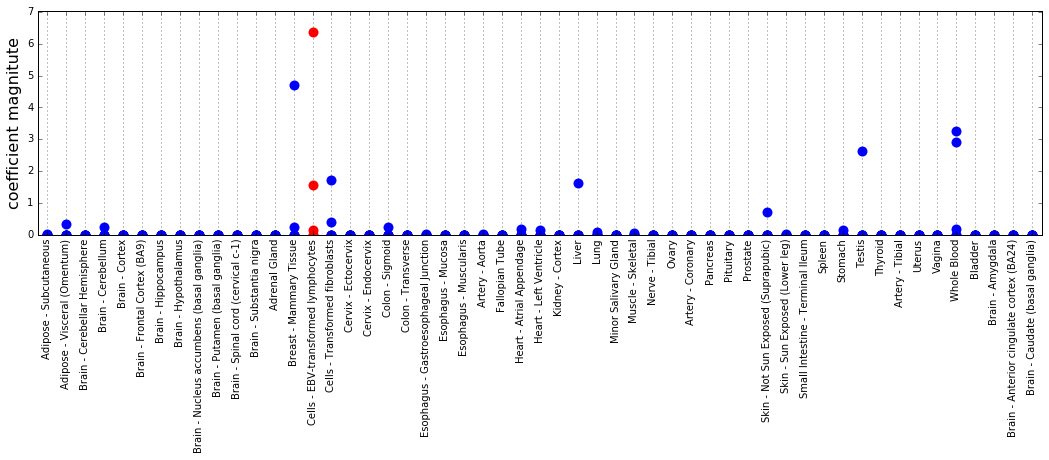

In [43]:
GO_ID = 'GO:2000514'
filename = '../GO_prediction/Results/pca_results_all_tissues_loss_l1_neg_0/logreg_' + GO_ID + '.txt'
[score, coeffs] = get_info(filename)

print 'ROC AUC SCORE: ',score

GOmap = map_GO_to_GTEX()
tissues = GOmap[GO_ID]
plot_coeff(GO_ID,coeffs,highlight = tissues,)

#### Coefficients for GO:0061337 - cardiac conduction

ROC AUC SCORE:  0.7275


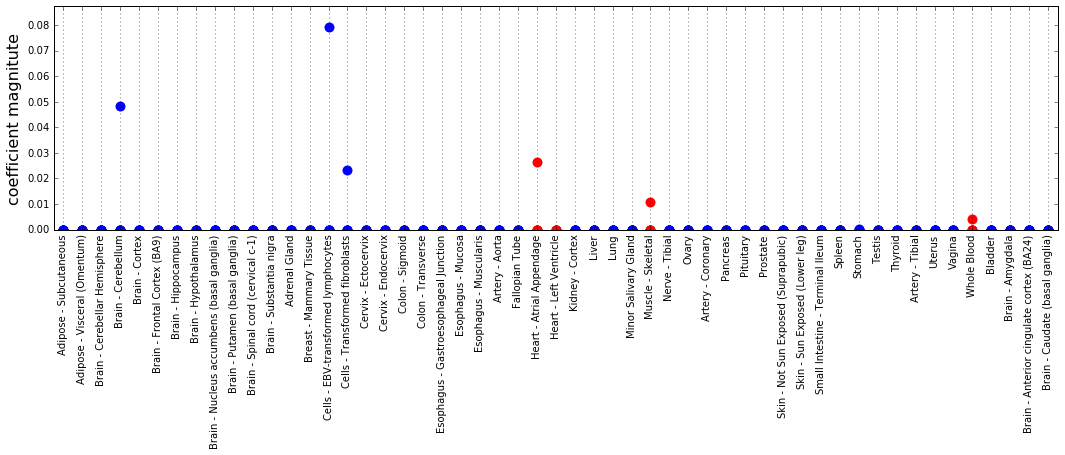

In [44]:
GO_ID = 'GO:0061337'
filename = '../GO_prediction/Results/pca_results_all_tissues_loss_l1_neg_0/logreg_' + GO_ID + '.txt'
[score, coeffs] = get_info(filename)

print 'ROC AUC SCORE: ',score

GOmap = map_GO_to_GTEX()
tissues = GOmap[GO_ID]
plot_coeff(GO_ID,coeffs,highlight = tissues)

#### Coefficients for GO:0050671 - positive regulation of lymphocyte proliferation

ROC AUC SCORE:  0.5712


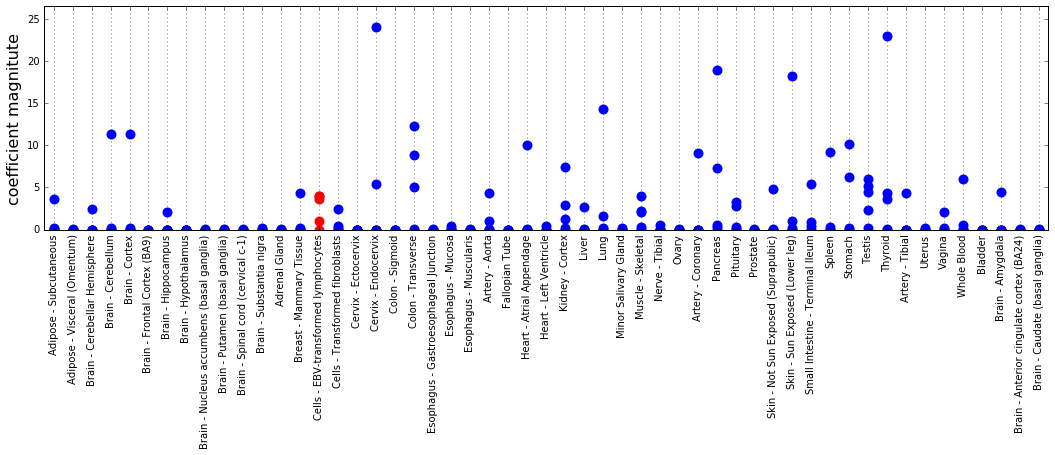

In [45]:
GO_ID = 'GO:0050671'
filename = '../GO_prediction/Results/pca_results_all_tissues_loss_l1_neg_0/logreg_' + GO_ID + '.txt'
[score, coeffs] = get_info(filename)

print 'ROC AUC SCORE: ',score

GOmap = map_GO_to_GTEX()
tissues = GOmap[GO_ID]
plot_coeff(GO_ID,coeffs,highlight = tissues)

#### Coefficients for GO:0045638 - negative regulation of myeloid cell differentiation

ROC AUC SCORE:  0.64453125


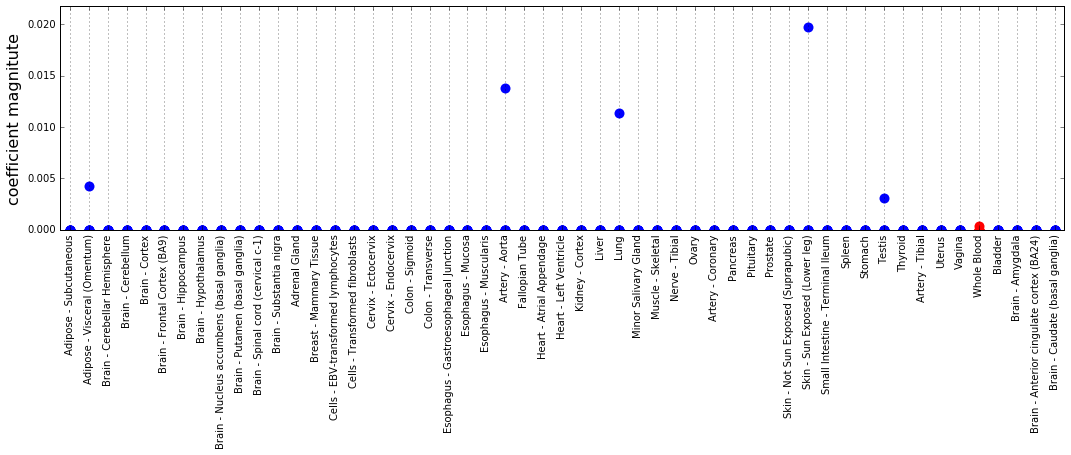

In [46]:
GO_ID = 'GO:0045638'
filename = '../GO_prediction/Results/pca_results_all_tissues_loss_l1_neg_0/logreg_' + GO_ID + '.txt'
[score, coeffs] = get_info(filename)

print 'ROC AUC SCORE: ',score

GOmap = map_GO_to_GTEX()
tissues = GOmap[GO_ID]
plot_coeff(GO_ID,coeffs,highlight = tissues)

#### Coefficients for GO:0003009 - skeletal muscle contraction

ROC AUC SCORE:  0.916666666667


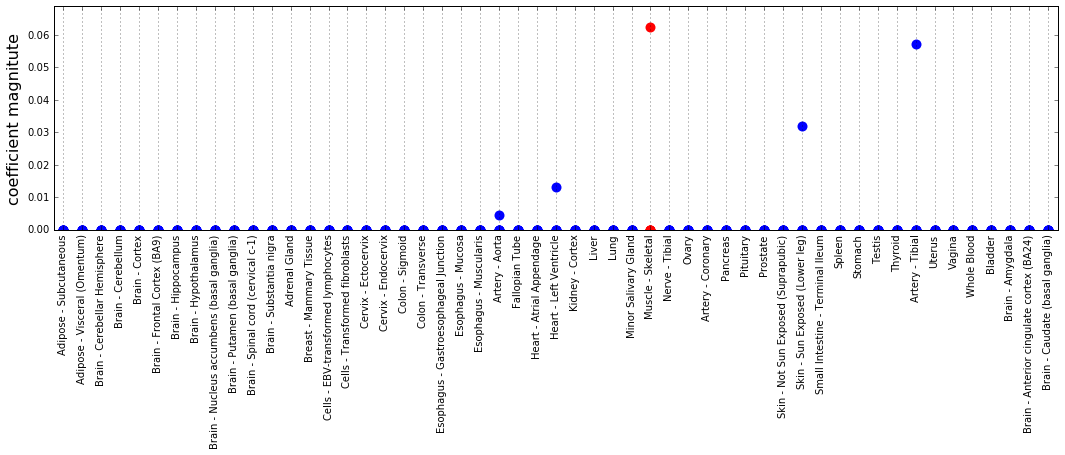

In [47]:
GO_ID = 'GO:0003009'
filename = '../GO_prediction/Results/pca_results_all_tissues_loss_l1_neg_0/logreg_' + GO_ID + '.txt'
[score, coeffs] = get_info(filename)

print 'ROC AUC SCORE: ',score

GOmap = map_GO_to_GTEX()
tissues = GOmap[GO_ID]
plot_coeff(GO_ID,coeffs,highlight = tissues)

#### Triple Boxplot for four example tissues

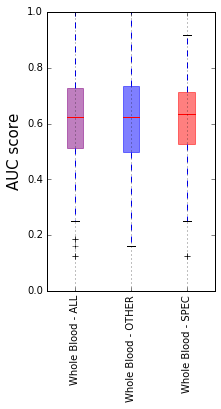

In [75]:
results_dir = '../GO_prediction/Results/full_results_1_tissue_loss_l2_neg_0/'
# Get all GO terms   
inputFilename = '../data/GO_terms_final_gene_counts.txt'
GO_list_file = open(inputFilename)
GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')

#all_tissues = get_tissue_list('../data/tissues.txt')
# all_tissues = ['Whole Blood','Muscle - Skeletal','Adipose - Subcutaneous','Brain - Anterior cingulate cortex (BA24)']
all_tissues = ['Whole Blood']
GTEX_to_GO = map_GTEX_to_GO(map_GO_to_GTEX())

# Sort order by number of samples
GTEX_to_cols = map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order

# Make tripled labels
labels = np.array(all_tissues)[index_order]
all_labels = np.array([[label + ' - ALL',label + ' - OTHER',label + ' - SPEC'] for label in labels])
all_labels = all_labels.flatten()

aucs_spec = [[] for tissue in all_tissues]
aucs_other = [[] for tissue in all_tissues]
aucs_all = [[] for tissue in all_tissues]

for i,tissue in enumerate(labels):
    
    terms = GTEX_to_GO[tissue]
    for GO in GO_list:
        file_name = results_dir + GO + '_neg_0/'
        auc = get_1_tissue_aucs(GO, [tissue], file_name)
        aucs_all[i] = np.append(aucs_all[i],auc)
        if GO in terms:
            aucs_spec[i] = np.append(aucs_spec[i],auc)
        else:
            aucs_other[i] = np.append(aucs_other[i],auc)

full_spec = []
full_other = []
full_all = []
for i in range(len(all_tissues)):
    full_all.append(aucs_all[i])
    full_all.append([])
    full_all.append([])
    full_other.append([])
    full_other.append(aucs_other[i])
    full_other.append([])
    full_spec.append([])
    full_spec.append([])
    full_spec.append(aucs_spec[i])


plt.figure(figsize=(3,5))
plt.margins(0.01)
plt.ylim([0,1])
ax = plt.gca()
ax.xaxis.grid(which='both')
ax.set_ylabel('AUC score',size=15)
# ax.set_title(all_tissues[0])
plt.xticks(range(len(all_labels)), all_labels, rotation='vertical')

box_all = ax.boxplot(full_all,labels=all_labels,patch_artist=True)
for patch in box_all['boxes']:
    patch.set_color('purple')
    patch.set_alpha(0.5)
    
box_spec = ax.boxplot(full_spec, labels=all_labels,patch_artist=True)
for patch in box_spec['boxes']:
    patch.set_color('red')
    patch.set_alpha(0.5)

box_other = ax.boxplot(full_other, labels=all_labels,patch_artist=True)
for patch in box_other['boxes']:
    patch.set_color('blue')
    patch.set_alpha(0.5)

plt.show()

# In the plot below, each tissue has three columns. The blue column shows boxplot of AUC scores on all GO terms,
# as predicted by this tissue. The green column shows boxplot of AUC scores on all NON-associated GO terms,
# as predicted by this tissue. The red column shows boxplot of AUC scores on all GO terms associate with this tissue,
# as predicted by this tissue.
# Note that many tissues lack a red column. These have no associated GO terms. They may also only have one, in which
# case there is a line, but no box.

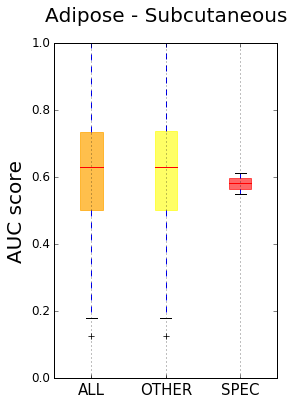

In [100]:
results_dir = '../GO_prediction/Results/full_results_1_tissue_loss_l2_neg_0/'
# Get all GO terms   
inputFilename = '../data/GO_terms_final_gene_counts.txt'
GO_list_file = open(inputFilename)
GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')

#all_tissues = get_tissue_list('../data/tissues.txt')
# all_tissues = ['Whole Blood','Muscle - Skeletal','Adipose - Subcutaneous','Brain - Anterior cingulate cortex (BA24)']
all_tissues = ['Adipose - Subcutaneous']
GTEX_to_GO = map_GTEX_to_GO(map_GO_to_GTEX())

# Sort order by number of samples
GTEX_to_cols = map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order

# Make tripled labels
labels = np.array(all_tissues)[index_order]
all_labels = np.array([['ALL','OTHER','SPEC'] for label in labels])
all_labels = all_labels.flatten()

aucs_spec = [[] for tissue in all_tissues]
aucs_other = [[] for tissue in all_tissues]
aucs_all = [[] for tissue in all_tissues]

for i,tissue in enumerate(labels):
    
    terms = GTEX_to_GO[tissue]
    for GO in GO_list:
        file_name = results_dir + GO + '_neg_0/'
        auc = get_1_tissue_aucs(GO, [tissue], file_name)
        aucs_all[i] = np.append(aucs_all[i],auc)
        if GO in terms:
            aucs_spec[i] = np.append(aucs_spec[i],auc)
        else:
            aucs_other[i] = np.append(aucs_other[i],auc)

full_spec = []
full_other = []
full_all = []
for i in range(len(all_tissues)):
    full_all.append(aucs_all[i])
    full_all.append([])
    full_all.append([])
    full_other.append([])
    full_other.append(aucs_other[i])
    full_other.append([])
    full_spec.append([])
    full_spec.append([])
    full_spec.append(aucs_spec[i])


plt.figure(figsize=(4,6))
plt.margins(0.01)
plt.ylim([0,1])
ax = plt.gca()
ax.xaxis.grid(which='both')
ax.set_ylabel('AUC score',size=20)
ax.set_title(all_tissues[0],size=20)
ttl = ax.title
ttl.set_position([.5, 1.05])
plt.xticks(range(len(all_labels)), all_labels, size=15)
plt.yticks(size=12)


box_all = ax.boxplot(full_all,labels=all_labels,patch_artist=True)
for patch in box_all['boxes']:
    patch.set_color('orange')
    patch.set_alpha(0.7)
    
box_spec = ax.boxplot(full_spec, labels=all_labels,patch_artist=True)
for patch in box_spec['boxes']:
    patch.set_color('red')
    patch.set_alpha(0.6)

box_other = ax.boxplot(full_other, labels=all_labels,patch_artist=True)
for patch in box_other['boxes']:
    patch.set_color('yellow')
    patch.set_alpha(0.6)

    
plt.savefig(all_tissues[0].replace(' ','_')+'_3box.png',bbox_inches='tight')
plt.show()

# In the plot below, each tissue has three columns. The blue column shows boxplot of AUC scores on all GO terms,
# as predicted by this tissue. The green column shows boxplot of AUC scores on all NON-associated GO terms,
# as predicted by this tissue. The red column shows boxplot of AUC scores on all GO terms associate with this tissue,
# as predicted by this tissue.
# Note that many tissues lack a red column. These have no associated GO terms. They may also only have one, in which
# case there is a line, but no box.